***
# Exercise: _Anomaly Detection Methods_
***

In this exercise, we want to compare existing anomaly detection methods on a variety of real-world multi-variate benchmark datasets. Moreover, we will implement a recent method that is both simple and elegant as well as powerful and fast.

1. LODA: Leight-weight Online Detector of Anomalies
    - Implement LODA (paper is provided) using the pyOD framework
    - Evaluate against competitors
2. Unsupervised vs Supervised Outlier Detection
    - Implement an regression and classification method (sklearn-based)
    - Evaluate and discuss the results on various datasets
3. High-dimensional Outlier Detection
    - Read the provided material
    - Check empirically if the concentration of distances condition is fulfilled


### Datasets

The datasets used here are available at the Outlier Detection DataSets (ODDS) libraryand can be downloaded from http://odds.cs.stonybrook.edu. Most of the datasets are processed datasets from other sources (e.g. mnist) to meet anomaly detection benchmark standards, e.g. labeled anomalies rather than classes. Further information for each dataset is available at http://odds.cs.stonybrook.edu.

In [1]:
import os
import sys
from time import time

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.io import loadmat
import scipy.spatial.distance as dist

from pyod.models.base import BaseDetector
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.pca import PCA

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline

### 1. LODA: Leight-weight Online Detector of Anomalies

In this first round, we will implement a recent, popular anomaly detector based on the pyOD framework
(https://github.com/yzhao062/pyod). You should have received a copy of the paper [1] by now and the task is, 
to read the paper carefully and implement the proposed method into the LODA class skeleton below.

[1] T. Pevny, “Loda: Lightweight on-line detector of anomalies,” Mach. Learn., vol. 102, pp. 275–304, 2016.


Some hints:

- The cumulative sum of a histogram needs to sum to one. However, unless unity width bins are used (which is not the case) and density=True, this will not happen:

    _If density=True, the result is the value of the probability density function at the bin, normalized such that the integral over the range is 1. Note that the sum of the histogram values will not be equal to 1 unless bins of unity width are chosen._
    
    
- -log(x) will produce 'inf' values and hence, pseudo-counts are needed before normalizing the histograms

In [2]:
class LODA(BaseDetector):

    def __init__(self, contamination=0.1, n_bins=10, n_random_cuts=100, **kwargs):
        super(LODA, self).__init__(contamination=contamination)
        self.n_bins = n_bins
        self.n_random_cuts = n_random_cuts
        self.weights = np.ones(n_random_cuts, dtype=np.float) / n_random_cuts

    def fit(self, X, y=None):
        n_components = X.shape[1]
        n_nonzero_components = np.sqrt(n_components)
        n_zero_components = n_components - np.int(n_nonzero_components)
        
        self.projections = np.random.randn(self.n_random_cuts, n_components)
        self.histograms = np.zeros((self.n_random_cuts, self.n_bins))
        self.limits = np.zeros((self.n_random_cuts, self.n_bins+1))
        for i in range(self.n_random_cuts):
            rands = np.random.permutation(n_components)[:n_zero_components]
            self.projections[i, rands] = 0.
            projected_data = self.projections[i, :].dot(X.T)
            self.histograms[i, :], self.limits[i, :] = np.histogram(projected_data, bins=self.n_bins, density=False)
            self.histograms[i, :] += 1e-12
            self.histograms[i, :] /= np.sum(self.histograms[i, :])            
        return self

    def decision_function(self, X):
        pred_scores = np.zeros([X.shape[0], 1])
        for i in range(self.n_random_cuts):
            projected_data = self.projections[i, :].dot(X.T)
            inds = np.searchsorted(self.limits[i, :self.n_bins-1], projected_data, side='left')
            pred_scores[:, 0] += -self.weights[i]*np.log(self.histograms[i, inds])
        pred_scores /= self.n_random_cuts
        return pred_scores.ravel()

In [4]:
# Define data file and read X and y
mat_file_list = ['arrhythmia.mat',
                 'cardio.mat',
                 'glass.mat',
                 'ionosphere.mat',
                 'letter.mat',
                 'lympho.mat',
                 'mnist.mat',
#                  'musk.mat',
#                  'optdigits.mat',
                 'pendigits.mat',
                 'pima.mat',
#                  'satellite.mat',
                 'satimage-2.mat',
#                  'shuttle.mat',
                 'vertebral.mat',
                 'vowels.mat',
                 'wbc.mat']

# mat_file_list = ['ionosphere.mat','arrhythmia.mat']


# Define nine outlier detection tools to be compared
random_state = np.random.RandomState(42)

df_columns = ['Data', '#Samples', '# Dimensions', 'Outlier Perc',
              'ABOD', 'CBLOF', 'FB', 'HBOS', 'IForest', 'KNN', 'LOF', 'MCD', 'PCA', 'LODA']
roc_df = pd.DataFrame(columns=df_columns)
prn_df = pd.DataFrame(columns=df_columns)
time_df = pd.DataFrame(columns=df_columns)

for mat_file in mat_file_list:
    print("\n... Processing", mat_file, '...')
    mat = loadmat(os.path.join('../data', mat_file))

    X = mat['X']
    y = mat['y'].ravel()
    outliers_fraction = np.count_nonzero(y) / len(y)
    outliers_percentage = round(outliers_fraction * 100, ndigits=4)

    # construct containers for saving results
    roc_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    prn_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    time_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]

    # 60% data for training and 40% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    # standardizing data for processing
    X_train_norm, X_test_norm = standardizer(X_train, X_test)

    classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor': CBLOF(contamination=outliers_fraction, check_estimator=False, random_state=random_state),
        'Feature Bagging': FeatureBagging(contamination=outliers_fraction, check_estimator=False, random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction, random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Local Outlier Factor (LOF)': LOF(contamination=outliers_fraction),
        'Minimum Covariance Determinant (MCD)': MCD(contamination=outliers_fraction, random_state=random_state),
        'Principal Component Analysis (PCA)': PCA(contamination=outliers_fraction, random_state=random_state),
        'Lightweight on-line detector of anomalies (LODA)': LODA(contamination=outliers_fraction, random_state=random_state),
    }

    for clf_name, clf in classifiers.items():
        t0 = time()
        clf.fit(X_train_norm)
        test_scores = clf.decision_function(X_test_norm)
        t1 = time()
        duration = round(t1 - t0, ndigits=4)
        time_list.append(duration)

        roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
        prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

        print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, execution time: {duration}s'.format(
            clf_name=clf_name, roc=roc, prn=prn, duration=duration))

        roc_list.append(roc)
        prn_list.append(prn)

    temp_df = pd.DataFrame(time_list).transpose()
    temp_df.columns = df_columns
    time_df = pd.concat([time_df, temp_df], axis=0)

    temp_df = pd.DataFrame(roc_list).transpose()
    temp_df.columns = df_columns
    roc_df = pd.concat([roc_df, temp_df], axis=0)

    temp_df = pd.DataFrame(prn_list).transpose()
    temp_df.columns = df_columns
    prn_df = pd.concat([prn_df, temp_df], axis=0)


... Processing arrhythmia.mat ...
Angle-based Outlier Detector (ABOD) ROC:0.7687, precision @ rank n:0.3571, execution time: 1.5312s
Cluster-based Local Outlier Factor ROC:0.778, precision @ rank n:0.5, execution time: 0.0458s
Feature Bagging ROC:0.7736, precision @ rank n:0.5, execution time: 0.4039s
Histogram-base Outlier Detection (HBOS) ROC:0.8511, precision @ rank n:0.5714, execution time: 0.7957s
Isolation Forest ROC:0.8217, precision @ rank n:0.5, execution time: 0.2215s
K Nearest Neighbors (KNN) ROC:0.782, precision @ rank n:0.5, execution time: 0.0609s
Local Outlier Factor (LOF) ROC:0.7787, precision @ rank n:0.4643, execution time: 0.0495s
Minimum Covariance Determinant (MCD) ROC:0.8228, precision @ rank n:0.4286, execution time: 0.5286s
Principal Component Analysis (PCA) ROC:0.7997, precision @ rank n:0.5, execution time: 0.0523s
Lightweight on-line detector of anomalies (LODA) ROC:0.6211, precision @ rank n:0.3571, execution time: 0.0214s

... Processing cardio.mat ...
Ang

Angle-based Outlier Detector (ABOD) ROC:0.8165, precision @ rank n:0.2083, execution time: 1.5235s
Cluster-based Local Outlier Factor ROC:0.9997, precision @ rank n:0.9167, execution time: 0.0455s
Feature Bagging ROC:0.3699, precision @ rank n:0.0, execution time: 4.6817s
Histogram-base Outlier Detection (HBOS) ROC:0.9863, precision @ rank n:0.7917, execution time: 0.0162s
Isolation Forest ROC:0.9979, precision @ rank n:0.9167, execution time: 0.481s
K Nearest Neighbors (KNN) ROC:0.9467, precision @ rank n:0.2917, execution time: 0.7638s
Local Outlier Factor (LOF) ROC:0.3787, precision @ rank n:0.0, execution time: 0.6055s
Minimum Covariance Determinant (MCD) ROC:0.9946, precision @ rank n:0.5417, execution time: 1.7525s
Principal Component Analysis (PCA) ROC:0.9867, precision @ rank n:0.9167, execution time: 0.017s
Lightweight on-line detector of anomalies (LODA) ROC:0.9888, precision @ rank n:0.7083, execution time: 0.0324s

... Processing vertebral.mat ...
Angle-based Outlier Detect

In [5]:
print('ROC Performance')
roc_df

ROC Performance


,Data,#Samples,# Dimensions,Outlier Perc,ABOD,CBLOF,FB,HBOS,IForest,KNN,LOF,MCD,PCA,LODA
0,arrhythmia,452,274,14.6018,0.7687,0.778,0.7736,0.8511,0.8217,0.782,0.7787,0.8228,0.7997,0.6211
0,cardio,1831,21,9.6122,0.5668,0.8987,0.5667,0.8102,0.8726,0.7252,0.5313,0.7966,0.9237,0.8736
0,glass,214,9,4.2056,0.8079,0.7012,0.8384,0.6921,0.564,0.8079,0.8537,0.753,0.5244,0.5915
0,ionosphere,351,33,35.8974,0.9265,0.8129,0.8889,0.6258,0.8762,0.9356,0.8963,0.9505,0.8215,0.7736
0,letter,1600,32,6.25,0.8836,0.4774,0.8697,0.5598,0.5833,0.865,0.8439,0.8154,0.496,0.4478
0,lympho,148,18,4.0541,0.8873,0.9709,0.9564,0.9891,0.9782,0.9491,0.9527,0.9345,0.9636,0.9527
0,mnist,7603,100,9.2069,0.7911,0.781,0.7457,0.563,0.8129,0.8571,0.7387,0.9094,0.8536,0.6957
0,pendigits,6870,16,2.2707,0.7132,0.9743,0.5074,0.9242,0.951,0.7745,0.4949,0.8402,0.9349,0.8871
0,pima,768,8,34.8958,0.6452,0.7381,0.6222,0.7203,0.6767,0.703,0.6203,0.6796,0.6663,0.6084
0,satimage-2,5803,36,1.2235,0.8165,0.9997,0.3699,0.9863,0.9979,0.9467,0.3787,0.9946,0.9867,0.9888


In [6]:
print('Runtime Performance')
temp_df

Runtime Performance


,Data,#Samples,# Dimensions,Outlier Perc,ABOD,CBLOF,FB,HBOS,IForest,KNN,LOF,MCD,PCA,LODA
0,wbc,378,30,5.5556,0.25,0.5,0.5,0.5,0.5,0.375,0.5,0.5,0.5,0.5


### 2. Unsupervised vs Supervised Outlier Detection

In this section, we will examine the difference of unsupervised and supervised method and see what happens 
if we provide a growing number of labeled examples. Therefore, you have to implement/use two methods of your choice (from sklearn): one regression method and one classifier. Caveat here is that we will not do any kind of model selection after all, the goal is to study the general pattern and not tweak the last percentages of accuracy out of each model. I would advice to use _Ridge_ and _SVC_ from sklearn. 

Questions:
- Check what happens when you use the 'predict' function of the classifier rather than the "decision_function'
- Check the three datasets and discuss the results. When does unsupervised learning works best?
- Supervised does not seem too bad, right? Why is it still not a bad idea to apply unsupervised methods?
- What would be the best of two worlds, here?

In [7]:
def train_and_predict_regression(X_train_norm, y_train, X_test_norm, y_test):
    clf = Ridge(alpha=0.001, fit_intercept=True, copy_X=True) 
    clf.fit(X_train_norm, y_train)
    test_scores = clf.predict(X_test_norm)
    return round(roc_auc_score(y_test, test_scores), ndigits=4)

def train_and_predict_classifier(X_train_norm, y_train, X_test_norm, y_test):
    if np.any(y_train == +1) and np.any(y_train == 0):
        clf = SVC(C=1.) 
        clf.fit(X_train_norm, y_train)
        test_scores = clf.decision_function(X_test_norm)
#         test_scores = clf.predict(X_test_norm)
        return round(roc_auc_score(y_test, test_scores), ndigits=4)
    return 0.5  # random

File:  mnist.mat
File:  ionosphere.mat
File:  satimage-2.mat


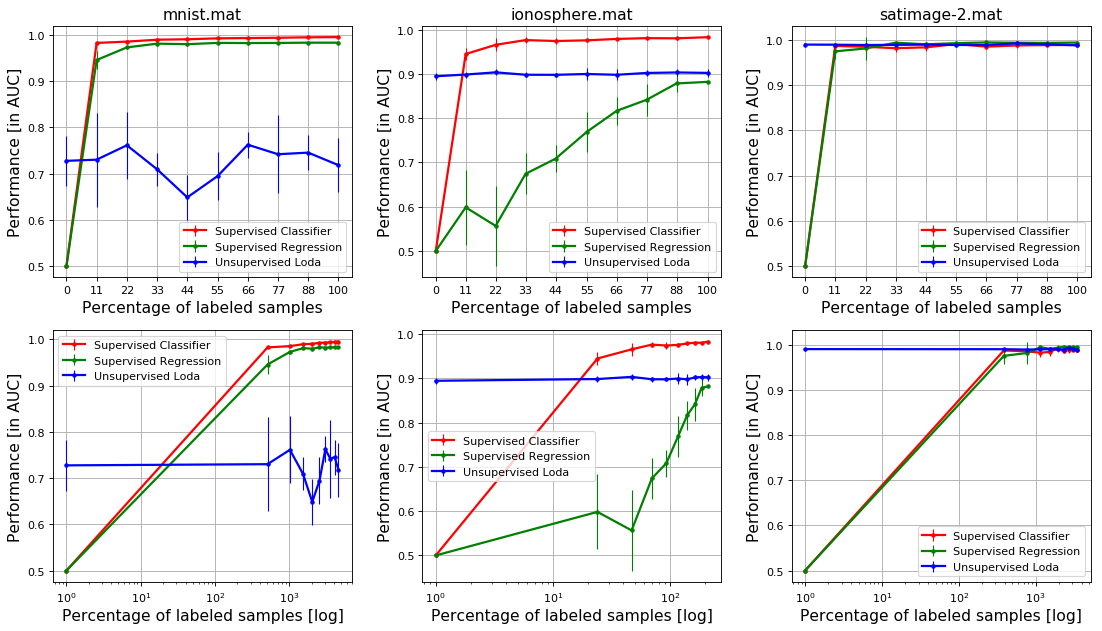

In [9]:
mat_file_list = ['mnist.mat', 'ionosphere.mat', 'satimage-2.mat']

reps = 5
samples = np.linspace(1, y_train.size, 10, dtype=np.int)

fig = plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
for f in range(len(mat_file_list)):
    mat = loadmat('../data/'+mat_file_list[f])
    print('File: ', mat_file_list[f])

    X = mat['X']
    y = mat['y'].ravel()

    # 60% data for training and 40% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
    samples = np.linspace(1, y_train.size, 10, dtype=np.int)

    # standardizing data for processing
    X_train_norm, X_test_norm = standardizer(X_train, X_test)

    rocs = np.zeros((3, len(samples), reps))
    for r in range(reps):
        for i in range(len(samples)):
            inds = np.random.permutation(y_train.size)[:samples[i]]
            rocs[0, i, r] = train_and_predict_classifier(X_train_norm[inds, :], y_train[inds], X_test_norm, y_test)
            rocs[1, i, r] = train_and_predict_regression(X_train_norm[inds, :], y_train[inds], X_test_norm, y_test)
            loda = LODA(contamination=outliers_fraction, random_state=random_state, n_random_cuts=250, n_bins=40)
            loda.fit(X_train_norm)
            test_scores = loda.decision_function(X_test_norm)
            rocs[2, i, r] = round(roc_auc_score(y_test, test_scores), ndigits=4)

    res = np.mean(rocs, axis=2)
    std = np.std(rocs, axis=2)

    plt.subplot(2, len(mat_file_list), f+1)
    plt.errorbar(samples, res[0, :], std[0, :], fmt='.-r', elinewidth=1., linewidth=2.)
    plt.errorbar(samples, res[1, :], std[1, :], fmt='.-g', elinewidth=1., linewidth=2.)
    plt.errorbar(samples, res[2, :], std[2, :], fmt='.-b', elinewidth=1., linewidth=2.)
    plt.legend(['Supervised Classifier', 'Supervised Regression', 'Unsupervised Loda'], fontsize=10)
    plt.xticks(samples, (samples/np.max(samples)*100.0).astype(np.int) )
    plt.xlabel('Percentage of labeled samples', fontsize=14)
    plt.ylabel('Performance [in AUC]', fontsize=14)
    plt.title(mat_file_list[f], fontsize=14)
    plt.grid()

    plt.subplot(2, len(mat_file_list), f+1+len(mat_file_list))
    plt.errorbar(samples, res[0, :], std[0, :], fmt='.-r', elinewidth=1., linewidth=2.)
    plt.errorbar(samples, res[1, :], std[1, :], fmt='.-g', elinewidth=1., linewidth=2.)
    plt.errorbar(samples, res[2, :], std[2, :], fmt='.-b', elinewidth=1., linewidth=2.)
    plt.legend(['Supervised Classifier', 'Supervised Regression', 'Unsupervised Loda'], fontsize=10)
    plt.xticks(samples, (samples/np.max(samples)*100.0).astype(np.int) )
    plt.xlabel('Percentage of labeled samples [log]', fontsize=14)
    plt.ylabel('Performance [in AUC]', fontsize=14)
    plt.semilogx()
    plt.grid()
    
plt.tight_layout()

### 3. High-dimensional Outlier Detection

This part is all about the paper by Beyer et al. [1] and, i.e. Theorem 1 that
formalized the problem of nearest neighbor based outlier detection in high-dimensional 
outlier detection settings. Some notation and inspiration also comes from the very good tutorial of 
Zimek et al. [2] and their corresponding survey paper [3].

##### Glossary
- $\mathbf{D}^{dims}$ : distances between samples from the data distribution and samples from the query distribution, both have dimensionality _dims_ (vector)
- $D_{max} = \max_i \mathbf{D}^{dims}_i$ : maximum distance in the set of all distances (scalar, similar with $D_{min}$)
- $\mathbf{X}^{dims}$ : sample from the data distribution having dimensionality _dims_
- $P$ : is a probability
- $\mathbf{E[X]}$ : is the expectation of X over some probability
- $var(X)$: equal to $\mathbf{E}[(X-\mathbf{E}[X])^2] = \mathbf{E}[X^2] - \mathbf{E}[X]^2$

##### References
[1] K. Beyer, J. Goldstein, R. Ramakrishnan, and U. Shaft, “When Is ‘Nearest Neighbor’ Meaningful?,” in International conference on database theory (ICDT), 1999, pp. 217–235.

[2] A. Zimek, E. Schubert, and H.-P. Kriegel, “A survey on unsupervised outlier detection in high-dimensional numerical data,” Statistical Analysis and Data Mining, vol. 5, no. 5. pp. 363–387, 2012.

[3] A. Zimek, E. Schubert, and H.-P. Kriegel, “Tutorial on Outlier Detection for High-dimensional Data,” 2013.

##### Side note
Normalization of distances is done by multiplying $1/\sqrt{dims}$ (for $\ell^p$-norms $1/\sqrt[p]{dims}$) since the maximum distance in the unit cube is $\sqrt{dims} = \sqrt{\sum_d 1^2}$ for euclidean metrics.

#### Empirical verification

The main insight of Theorem 1 is that as the dimensionality of data sets increases, the distance between 
some query point and to its nearest neighbor $D_{min}$ and its furthest neighbor $D_{max}$ will converge to the same value. That means $lim_{dims \rightarrow \infty}\; P\left( \frac{D_{max}}{D_{min}} - 1\leq \epsilon \right) = 1$ for any $\epsilon > 0$.

Lets check empirically in a standard (toy) setting if that is correct. Therefore, we are generating some Gaussian random data points (various cluster with random means and variance) with increasing dimensionality and uniformly distributed query points. Further, we will check for 3 distinct $\ell^p$-norm induced distance metrics (manhattan, euclidean and max norm).

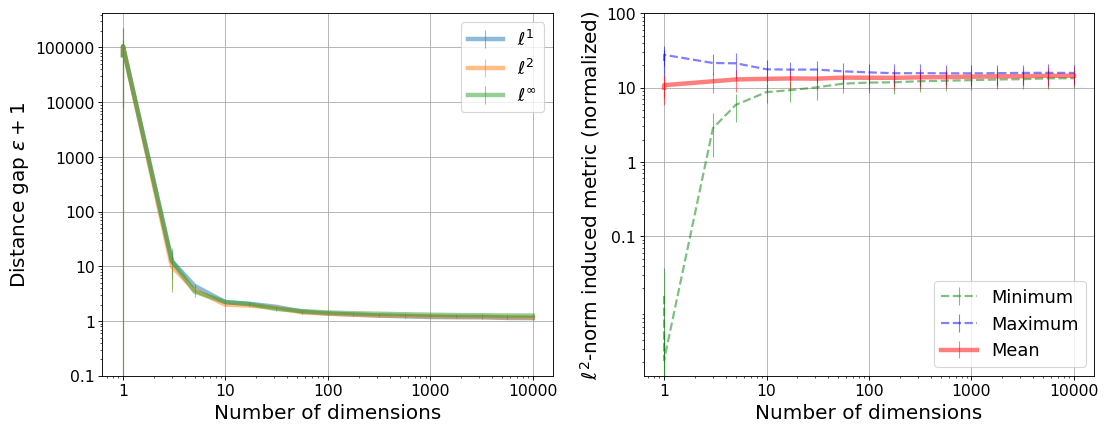

In [10]:
DIMS = np.logspace(0, 4, 17, dtype=np.int)
REPS = 3
CLUSTER = 3
res = np.zeros((REPS, len(DIMS), 3))
extremas = np.zeros((REPS, len(DIMS), 3))
for r in range(REPS):
    rndm_var = np.zeros(CLUSTER)
    rndm_mean = np.zeros(CLUSTER)
    for c in range(CLUSTER):
        rndm_var[c] = np.random.rand()
        rndm_mean[c] = 10.*np.random.randn()
    for d in range(len(DIMS)):
        X_data = np.empty((DIMS[d], 0))
        for c in range(CLUSTER):
            X_data = np.append(X_data, rndm_var[c]*np.random.randn(DIMS[d], np.int(1000/CLUSTER)) + rndm_mean[c], axis=1)
        X_query = (np.random.rand(DIMS[d], 10)-0.5) * 2. * 2 * np.max(np.abs(X_data))
        # ok, lets measure the distance gap for various metrics
        D = dist.cdist(X_data.T, X_query.T, metric='minkowski', p=1)
        res[r, d, 0] = np.max(D)/np.min(D)
        D = dist.cdist(X_data.T, X_query.T, metric='minkowski', p=2)
        res[r, d, 1] = np.max(D)/np.min(D)
        # ..and store the euclidean min, max, mean values
        extremas[r, d, 0] = np.min(D) * 1./np.sqrt(DIMS[d])
        extremas[r, d, 1] = np.max(D) * 1./np.sqrt(DIMS[d])
        extremas[r, d, 2] = np.mean(D) * 1./np.sqrt(DIMS[d])
        D = dist.cdist(X_data.T, X_query.T, metric='chebyshev')
        res[r, d, 2] = np.max(D)/np.min(D)

plt.figure(figsize=(16, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.errorbar(DIMS, np.mean(res[:,:,0], axis=0), np.std(res[:,:,0], axis=0), alpha=0.5, linewidth=4, elinewidth=1)
plt.errorbar(DIMS, np.mean(res[:,:,1], axis=0), np.std(res[:,:,1], axis=0), alpha=0.5, linewidth=4, elinewidth=1)
plt.errorbar(DIMS, np.mean(res[:,:,2], axis=0), np.std(res[:,:,2], axis=0), alpha=0.5, linewidth=4, elinewidth=1)
plt.loglog()
plt.grid()
plt.xticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize=14)
plt.yticks([0.1, 1, 10, 100, 1000, 10000, 100000], [0.1, 1, 10, 100, 1000, 10000, 100000], fontsize=14)
plt.xlabel('Number of dimensions', fontsize=18)
plt.ylabel('Distance gap $\epsilon + 1$', fontsize=18)
plt.legend(['$\ell^1$', '$\ell^2$', '$\ell^\infty$'], fontsize=16)

plt.subplot(1, 2, 2)
plt.errorbar(DIMS, np.mean(extremas[:,:,0], axis=0), np.std(extremas[:,:,0], axis=0), fmt='--g', alpha=0.5, linewidth=2, elinewidth=1)
plt.errorbar(DIMS, np.mean(extremas[:,:,1], axis=0), np.std(extremas[:,:,1], axis=0), fmt='--b', alpha=0.5, linewidth=2, elinewidth=1)
plt.errorbar(DIMS, np.mean(extremas[:,:,2], axis=0), np.std(extremas[:,:,2], axis=0), fmt='-r', alpha=0.5, linewidth=4, elinewidth=1)
plt.loglog()
plt.grid()
plt.xticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize=14)
plt.yticks([0.1, 1, 10, 100], [0.1, 1, 10, 100], fontsize=14)
plt.xlabel('Number of dimensions', fontsize=18)
plt.ylabel('$\ell^2$-norm induced metric (normalized)', fontsize=18)
plt.legend(['Minimum', 'Maximum', 'Mean'], loc=4, fontsize=16) 

Whether or not distances concentrate depends on the following condition:

Assume that $lim_{dims \rightarrow \infty}\; var \left( \frac{\Vert \mathbf{X}^{dims}\Vert}{\mathbf{E}[\Vert\mathbf{X}^{dims}\Vert]} \right) = 0$, distances will concentrate.

Your task is to verify empirically this condition on a number of datasets. 
When does it not hold? 

In [11]:
def check_condition_empirically(X, n_reps, n_dims):
    dims = np.linspace(4, X.shape[1], n_dims, dtype=np.int)
    res = np.zeros((n_dims, n_reps))
    for r in range(n_reps):
        for i in range(n_dims):
            inds = np.random.permutation(n_dims)[:dims[i]]
            res[i, r] = np.var( np.linalg.norm(X[:, inds], axis=1) / np.mean(np.linalg.norm(X[:, inds], axis=1)))
    return np.mean(res, axis=1)

File:  mnist.mat
File:  wbc.mat
File:  ionosphere.mat
File:  satimage-2.mat


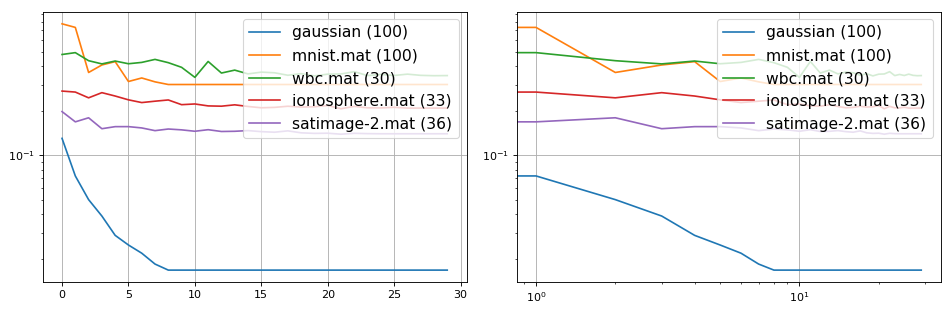

In [12]:
mat_file_list = ['gaussian', 'mnist.mat', 'wbc.mat', 'ionosphere.mat', 'satimage-2.mat']

n_reps = 10
n_dims = 30

res = np.zeros((len(mat_file_list), n_dims))

fig = plt.figure(figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
for f in range(len(mat_file_list)):
    X = np.random.randn(1000, 100)
    if not mat_file_list[f] == 'gaussian':
        mat = loadmat('../data/'+mat_file_list[f])
        print('File: ', mat_file_list[f])
        X = mat['X']
    X, _ = standardizer(X, X)
    res[f, :] = check_condition_empirically(X, n_reps, n_dims)

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(n_dims), res[f, :])

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(n_dims), res[f, :])

    mat_file_list[f] += ' ({0})'.format(X.shape[1])
    
plt.subplot(1, 2, 1)
plt.legend(mat_file_list, fontsize=14, loc=1)
plt.semilogy()
plt.grid()

plt.subplot(1, 2, 2)
plt.legend(mat_file_list, fontsize=14, loc=1)
plt.loglog()
plt.grid()

plt.tight_layout()